<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Using the Landlab ListricKinematicExtender component

*(Greg Tucker, University of Colorado Boulder, March 2021)*

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

This tutorial demonstrates how to use the `ListricKinematicExtender` component. `ListricKinematicExtender` models the vertical subsidence and lateral tectonic motion associated with a listric detachment fault. A listric fault is one that shallows with depth, such that the fault plane has a concave-upward profile. The word "kinematic" indicates that this component does not calculate the mechanics of stress and strain involved in an extensional fault; it simply aims to mimic them geometrically. The basic concept, described in detail below, is to divide the resulting tectonics into a vertical component and a horizontal component. The vertical component is modeled by imposing a subsidence rate that decays exponentially with distance from the fault's initial surface location. The horizontal component is modeled by shifting elevation values (and optionally other fields) by one cell at regular time intervals, based on a given extension rate. 

## Theory

### Describing a listric fault plane

Consider a fault plane with dip angle $\alpha$ relative to the horizontal. The fault plane has a listric shape, in which the dip angle at the surface is $\alpha_0$, and it becomes increasingly shallow with depth, ultimately asymptoting to horizontal at depth $h$ (we'll refer to $h$ as the detachment depth). We can express the dip angle in terms of gradient $G = \tan\alpha$, and $G_0 = \tan\alpha_0$. Let the gradient decay exponentially with distance from its surface trace, $x$, starting from the surface value $G_0$:

$$G(x) = G_0 e^{-x/\lambda}$$

where $\lambda$ is a length scale that we'll define in a moment. Because $G$ is the rate of change of fault plane elevation, $z$ with distance $x$, we can write:

$$\frac{dz}{dx} = -G_0 e^{-x/\lambda}\hskip1em\mbox{(1)}$$

Integrating,

$$z(x) = G_0\lambda e^{-x/\lambda} + C$$

Evaluate constant of integration by noting that $z = z_0$ (the elevation of the initial surface trace) at $x = 0$,

$$z_0 = G_0\lambda + C$$

so

$$z(x) = z_0 - G_0\lambda (1 - e^{-x/\lambda})$$

Note that the fault elevation asymptotes to a detachment depth $h = G_0\lambda$. This gives us a physical basis for $\lambda$, and means we can express our fault plane geometry by $h$ instead of $\lambda$:

$$\boxed{z(x) = z_0 - h \left(1 - e^{-x G_0 / h}\right)}$$

Let's plot it:

Text(0, 0.5, 'Fault plane elevation (km)')

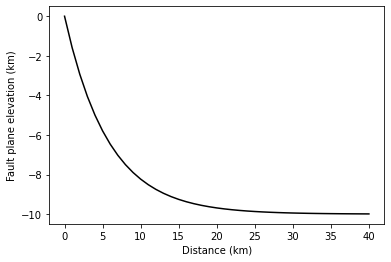

In [1]:
import numpy as np
import matplotlib.pyplot as plt

alpha0 = 60.0 # fault dip at surface, degrees
z0 = 0.0 # elevation of surface trace
h = 10.0 # detachment depth, km

G0 = np.tan(np.deg2rad(60.0))
x = np.arange(0, 41.0)
z = z0 - h * (1.0 - np.exp(-x * G0 / h))

plt.plot(x, z, 'k')
plt.xlabel('Distance (km)')
plt.ylabel('Fault plane elevation (km)')

### Describing subsidence due to fault motion

From here, we can think about the subsidence rate of the hangingwall as a function of horizontal extension velocity, $u$. We can think of the hangingwall as an enormous, floppy sled that glides down the slope of the fault plane. Consider a point on the hangingwall. In the reference frame of the footwall, the thickness of the underlying hangingwall block shrinks over time as the hangingwall moves to the "right". If the fault plane is fixed, then the vertical rate of change of surface elevation, $v$, in a reference frame fixed to the footwall, is equal to the rate of change of local hangingwall thickness. The time rate of change of hangingwall thickness, $H_h$, is the product of the *spatial* gradient in thickness times the extension rate, $u$,

$$v = \frac{dH_h}{dt} = -u \frac{dH_h}{dx}$$

If the footwall is rigid (which we'll assume for now), the time rate of change of surface elevation due to hangingwall motion---again, in the reference frame of the footwall---equals the rate of change of hangingwall thickness.

The hangingwall thickness equals its surface elevation, $\eta(x,t)$, minus the fault-plane elevation, $z(x)$:

$$H_h(x,t) = \eta(x,t) - (z_0 - h (1 - e^{-x G_0 / h}))$$

where again $x$ is the initial location of the fault's surface trace. Suppose that there were no erosion or sedimentation. We can rewrite the above as

$$H_h(x,t) = \eta(x-ut, 0) - (z_0 - h (1 - e^{-(x-ut) G_0 / h}))$$

As an illustration, suppose the topographic surface is initially level and equal to zero. In that case,

$$H_h(x,t) = h (1 - e^{-(x-ut) G_0 / h}))$$

The corresponding height of the topographic surface at a given position and time is

$$\boxed{\eta(x,t) = z(x) + H_h(x,t) =  h e^{-x G_0 / h} - h e^{-(x-ut) G_0 / h}}$$

Our implementation trick will be to apply this subsidence to grid cells in an Eulerian frame, but also capture the horizontal component of motion by  shifting hangingwall grid cells every time the cumulative horizontal displacement equals or exceeds one grid cell width.

The block of code below shows an example of an initially level topographic surface that has accumulated subsidence over time according to the above equation. Note how the subsidence profile reflects the "rightward" motion of the hangingwall relative to the (fixed) footwall.

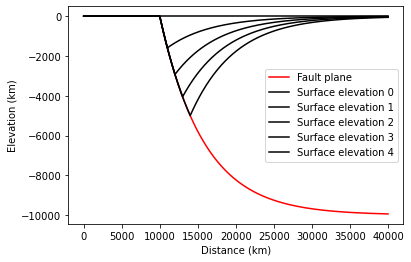

In [2]:
dt = 100000.0 # time span, y
xf = 10000.0 # initial location of surface trace of fault, m
u = 0.01 # extension rate, m/y
h = 10000.0 # detachment depth, m
nprofiles = 5

x = np.arange(0.0, 40100.0, 100.0)
dist_from_fault = np.maximum(x - xf, 0.0)
z = z0 - h * (1.0 - np.exp(-dist_from_fault * G0 / h))

plt.plot(x, z, 'r', label='Fault plane')

for i in range(nprofiles):
    t = i * dt
    shifted_dist_from_fault = np.maximum(dist_from_fault - u * t, 0.0)

    # WAIT 
    # Calculate the surface topography
    eta = (h * (np.exp( -dist_from_fault * G0 / h)
                - np.exp( -shifted_dist_from_fault * G0 / h)))
    
    # Calculate thickness
    #thickness = h * (1.0 - np.exp(-shifted_dist_from_fault * G0 / h))

    # eta won't be less than the fault-plane elevation
    eta[eta < z] = z[eta < z]

    plt.plot(x, eta, 'k', label='Surface elevation ' + str(i))
    #plt.plot(x, thickness, 'b', label='Thickness' + str(i))

plt.xlabel('Distance (km)')
plt.ylabel('Elevation (km)')
plt.legend()

## Numerical implementation

The numerical approach is to divide the problem into two parts: subsidence that results from the descent of the hangingwall as it moves along the fault plane, and lateral translation of topography. The mathematical basis for this starts with expressing the hangingwall thickness, $H_f$, in terms of surface topography, $\eta$ and fault plane elevation, $z$:

$$H_f = \eta - z$$

We can therefore decompose the local rate of hangingwall subsidence (in the footwall frame of reference) into two components:

$$v = -u \left( \frac{d\eta}{dx} - \frac{dz}{dx}\right)$$

The second term represents subsidence of hangingwall rock that occurs because of downward motion along the fault plane. Substituting equation (1), this component is:

$$v_s = -u G_0 \exp(-x G_0 / h)$$

where $x$ is defined as distance from the original position of the surface fault trace. However, it only applies where the hangingwall is still present, and not to those locations where the hangingwall has slipped off to reveal the fault plane at the surface. Therefore, we will track the $x$ coordinate of the "left" edge of the hangingwall, and only apply this component of subsidence to those locations. The subsidence rate component $v_s$ is applied continuously to the topography, i.e., at every time step.

The second component, represented by $-u d\eta / dx$, represents the local subsidence that occurs because the topography is translating lateral with respect to the footwall. This component we do *not* want to apply continuously, because it would result in artificial diffusion of the topography. Instead, the algorithm periodically shifts the topography in the entire hangingwall portion of the grid by one cell to the "right". To accomplish this, the algorithm keeps track of cumulative lateral motion since the last shift, executing a new shift whenever that value exceeds one grid-cell width, and decrementing the cumulative lateral motion by one cell width. This method preserves the hangingwall topography (and any other associated fields), at the expense of introducing episodic lateral tectonic motion. However, because of the direct translation, the *relative* change in topography between adjacent cells is minimized.

### Fields

The `ListricKinematicExtender` requires `topographic__elevation` as a field; it applies subsidence to this field. It creates one output field: `subsidence_rate` records the latest subsidence rate at grid nodes.

There are also two optional fields that are used only if the user selects the `track_thickness` option, which is designed to support combining this component with lithosphere flexure by also tracking changes in crustal thickness that result from extension. `upper_crust_thickness` is an input-and-output field that contains the current thickness of the upper crust (however defined), and the `cumulative_subsidence_depth` field records the accumulated subsidence since the most recent horizontal shift (see below).

### Vertical subsidence

The `run_one_step()` method calculates the subsidence rate field at nodes using the exponential function above, then multiplies this by the given time-step duration `dt` and subtracts this value from the node elevations.

Alternatively, a user may wish to calculate the subsidence rates without having the compent actually apply them to the elevation field. To accomplish this, the component provides a public function `update_subsidence_rate`. This function updates the subsidence rate field without changing elevations.

### Horizontal motion

To represent horizontal motion of the hangingwall relative to the footwall (which is the fixed datum), the component keeps track of cumulative horizontal motion, updating it each time `run_one_step` is called. When the cumulative motion equals or exceeds one grid-cell width, the component shifts the elevation values in the hangingwall portion of the domain to the "right", representing offset of one cell width. The cumulative horizontal offset is then decremented by one grid cell. The position of the "left" edge of the hangingwall is also increased by one cell width (its initial position is the user-specified fault position). This means that the boundary between the footwall and hangingwall also migrates to the "right" at the specified extension rate, and that the area of active subsidence gradually shrinks over time. However, the subsidence rate profile is still calculated using fault position. Mathematically, this can be expressed as:

$$v(x, t) = \begin{cases}
  -v G_0 \exp ( -(x - x_f) G_0 / h ) & \mbox{if } x > x_h(t) \\
  0 & \mbox{otherwise}
\end{cases}$$

$$x_h(t) = x_f + u t$$

where $x_f$ is the initial $x$ position of the surface fault trace, and $x_h$ represents the "left" edge of the hangingwall.

In addition to "shifting" elevation values, the user may pass a list of node field names in the `fields_to_shift` parameter, and these will also be shifted.

### Integrating with flexure

By itself, `ListricKinematicExtender` does not include rift-shoulder uplift, which in nature (at least in the author's understanding) occurs as a result of flexural isostatic uplift in response to extensional thinning of the crust, and also possibly as a result of thermal isostatic uplift in the underlying mantle. To handle the first of these, `ListricKinematicExtender` is designed to work together with a flexural isostasy component. The basic idea is to calculate explicitly the thinning of the crustal column that results from extension, so that this reduction in crustal thickness can be used by an isostasy component such as `Flexure`.

The basic concept behind `ListricKinematicExtender` is that thinning occurs when the hangingwall block is dragged away from the footwall, in effect sliding down the fault plane, as illustrated in the plot of topography and fault plane above. In order to combine with a flexural isostasy component, we need to keep track of the progressive reduction in crustal thickness. This tracking is activated when the `track_crustal_thickness` option is set to `True` (the default is `False`). The user must provide an `upper_crust_thickness` node field. As noted above, the algorithm separates the vertical and horizontal components of motion, with horizontal motion only explicitly implemented when the cumulative displacement equals or exceeds a full grid-cell width. In keeping with this approach, the thickness field is only modified when a cell-shift occurs. But that approach could cause a problem if one wishes to incorporate flexural isostasy: a natural approach to flexural isostasy is to keep track of an evolving crustal thickness field (which thins under erosion and thickens under deposition), and calculate surface topography as the sum of a crustal datum, flexural offset, and crustal thickness above the datum. To enable this approach, we somehow need to keep track of the extensional subsidence that occurs *between* horizontal offsets. To do this, the `ListricKinematicExtender` keeps track of cumulative subsidence since the last horizontal shift. This quantity is tracked by the optional output field `cumulative_subsidence_depth` (the field is created only if the user sets `track_crustal_thickness` to `True`). One can then calculate elevation at any time step by summing a crustal datum elevation, the thickness of crust above this datum, the isostatic deflection, and the cumulative extensional subsidence. Whenever a shift occurs, the thickness field is included in the shift: those crustal columns to the "right" of the hangingwall edge are shifted by one cell, along with the topography. The cumulative subsidence since the last shift is then subtracted from the thickness field to record the accumulated thinning associated with that shift. This method effectively captures the thinning of crust along a listric fault plane without needing to explicitly track the fault plane or of separate hangingwall and footwall columns.

## Examples

### Example 1: Quasi-1D

The first example uses a quasi-1D setup to represent an initially level topography on which subsidence progressively accumulates. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid, imshow_grid
from landlab.components import ListricKinematicExtender

In [4]:
# parameters
nrows = 3
ncols = 51
dx = 1000.0 # grid spacing, m
nsteps = 20 # number of iterations
dt = 2.5e5 # time step, y
extension_rate = 0.001 # m/y
detachment_depth = 10000.0 # m
fault_dip = 60.0 # fault dip angle, degrees
fault_loc = 10000.0 # m from left side of model

In [5]:
# Create grid and elevation field
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)
elev = grid.add_zeros('topographic__elevation', at='node')

# Instantiate component
extender = ListricKinematicExtender(grid,
                                    extension_rate=extension_rate,
                                    fault_dip=fault_dip,
                                    fault_location=fault_loc,
                                    detachment_depth=detachment_depth,
                                   )

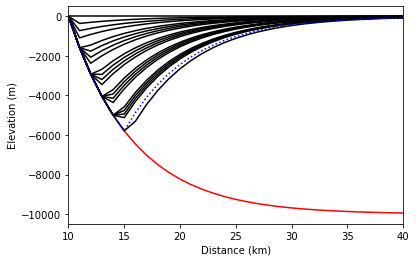

In [6]:
# Plot the starting elevations, in cross-section (middle row)
midrow = np.arange(ncols, 2 * ncols, dtype=int)
plt.plot(grid.x_of_node[midrow] / 1000.0, elev[midrow], 'k')
plt.xlabel('Distance (km)')
plt.ylabel('Elevation (m)')
plt.xlim([10.0, 40.0])

# Add a plot of the fault plane
dist_from_fault = grid.x_of_node - fault_loc
dist_from_fault[dist_from_fault < 0.0] = 0.0
x0 = detachment_depth / np.tan(np.deg2rad(fault_dip))
fault_plane = -(detachment_depth
                * (1.0 - np.exp(-dist_from_fault / x0)))
plt.plot(grid.x_of_node[midrow] / 1000.0, fault_plane[midrow], 'r')
                
for i in range(nsteps):
    extender.run_one_step(dt)
    plt.plot(grid.x_of_node[midrow] / 1000.0, elev[midrow], 'k')

# Add the analytic solution
total_time = nsteps * dt
G0 = np.tan(np.deg2rad(fault_dip))
shifted_dist_from_fault = np.maximum(dist_from_fault - extension_rate * total_time, 0.0)
elev_pred = (detachment_depth * (np.exp( -dist_from_fault * G0 / h)
                - np.exp( -(shifted_dist_from_fault * G0 / h))))
elev_pred = np.maximum(elev_pred, fault_plane)
plt.plot(grid.x_of_node[midrow] / 1000.0, elev_pred[midrow], 'b:')

### Example 2: quasi-1D with topography

In [7]:
period = 15000.0 # period of sinusoidal variations in initial topography, m
ampl = 500.0 # amplitude of variations, m

# Create grid and elevation field
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)
elev = grid.add_zeros('topographic__elevation', at='node')
elev[:] = ampl * np.sin(2 * np.pi * grid.x_of_node / period)

# Instantiate component
extender = ListricKinematicExtender(grid,
                                    extension_rate=extension_rate,
                                    fault_dip=fault_dip,
                                    fault_location=fault_loc,
                                    detachment_depth=detachment_depth,
                                   )

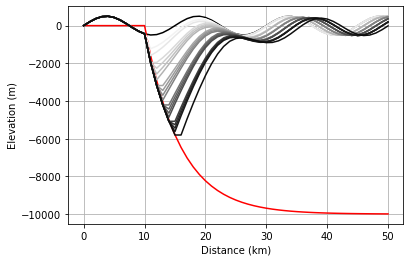

In [8]:
# Plot the starting elevations, in cross-section (middle row)
midrow = np.arange(ncols, 2 * ncols, dtype=int)
plt.plot(grid.x_of_node[midrow] / 1000.0, elev[midrow], 'k')
plt.xlabel('Distance (km)')
plt.ylabel('Elevation (m)')
plt.grid(True)

# Add a plot of the fault plane
dist_from_fault = grid.x_of_node - fault_loc
dist_from_fault[dist_from_fault < 0.0] = 0.0
x0 = detachment_depth / np.tan(np.deg2rad(fault_dip))
fault_plane = -(detachment_depth
                * (1.0 - np.exp(-dist_from_fault / x0)))
plt.plot(grid.x_of_node[midrow] / 1000.0, fault_plane[midrow], 'r')
                
for i in range(nsteps):
    extender.run_one_step(dt)
    c = 1.0 - i / nsteps
    plt.plot(grid.x_of_node[midrow] / 1000.0, elev[midrow], color=[c, c, c])

### Example 3: extending to 2D

In [11]:
from landlab import imshow_grid

# parameters
nrows = 31
ncols = 51
dx = 1000.0 # grid spacing, m
nsteps = 20 # number of iterations
dt = 2.5e5 # time step, y
extension_rate = 0.001 # m/y
detachment_depth = 10000.0 # m
fault_dip = 60.0 # fault dip angle, degrees
fault_loc = 10000.0 # m from left side of model
period = 15000.0 # period of sinusoidal variations in initial topography, m
ampl = 500.0 # amplitude of variations, m

In [12]:
# Create grid and elevation field
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)
elev = grid.add_zeros('topographic__elevation', at='node')
elev[:] = (ampl * np.sin(2 * np.pi * grid.x_of_node / period)
           * np.sin(2 * np.pi * grid.y_of_node / period))

# Instantiate component
extender = ListricKinematicExtender(grid,
                                    extension_rate=extension_rate,
                                    fault_dip=fault_dip,
                                    fault_location=fault_loc,
                                    detachment_depth=detachment_depth,
                                   )

/Users/gtucker/Dev/Landlab/landlab/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)
/Users/gtucker/Dev/Landlab/landlab/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


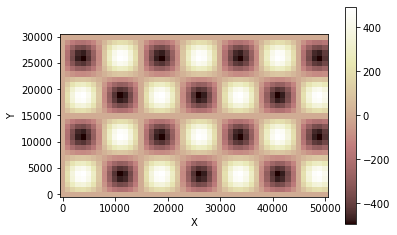

In [13]:
# Plot the starting topography
imshow_grid(grid, elev)

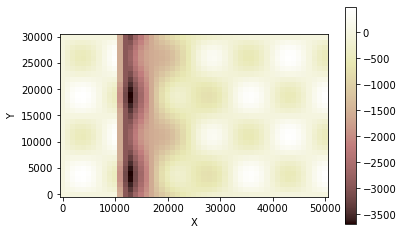

In [15]:
for i in range(nsteps // 2):
    extender.run_one_step(dt)
imshow_grid(grid, elev)

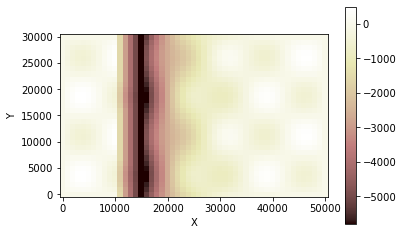

In [16]:
for i in range(nsteps // 2):
    extender.run_one_step(dt)
imshow_grid(grid, elev)

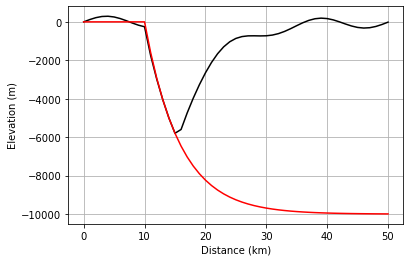

In [19]:
# Plot a cross-section
start_node = 6 * ncols
end_node = start_node + ncols
midrow = np.arange(start_node, end_node, dtype=int)
plt.plot(grid.x_of_node[midrow] / 1000.0, elev[midrow], 'k')
plt.xlabel('Distance (km)')
plt.ylabel('Elevation (m)')
plt.grid(True)

# Add a plot of the fault plane
dist_from_fault = grid.x_of_node - fault_loc
dist_from_fault[dist_from_fault < 0.0] = 0.0
x0 = detachment_depth / np.tan(np.deg2rad(fault_dip))
fault_plane = -(detachment_depth
                * (1.0 - np.exp(-dist_from_fault / x0)))
plt.plot(grid.x_of_node[midrow] / 1000.0, fault_plane[midrow], 'r')         

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>